## Simple results DG

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip



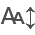

In [1]:
import pandas as pd
import numpy as np
!pip install seaborn
!pip install itables
import seaborn as sns
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)
from itables import show

from matplotlib import pyplot as plt



['rimes' 'icfhr_2016' 'rodrigo' 'saint_gall' 'bentham' 'washington' 'iam']
['iam' 'washington' 'bentham' 'rimes' 'saint_gall' 'rodrigo' 'icfhr_2016']


/tmp/ipykernel_1719094/828466311.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(['IAM', 'G.W.', 'Bentham', 'Rimes', 'S.G.', 'Rodrigo', 'ICFHR$_{2016}$'])


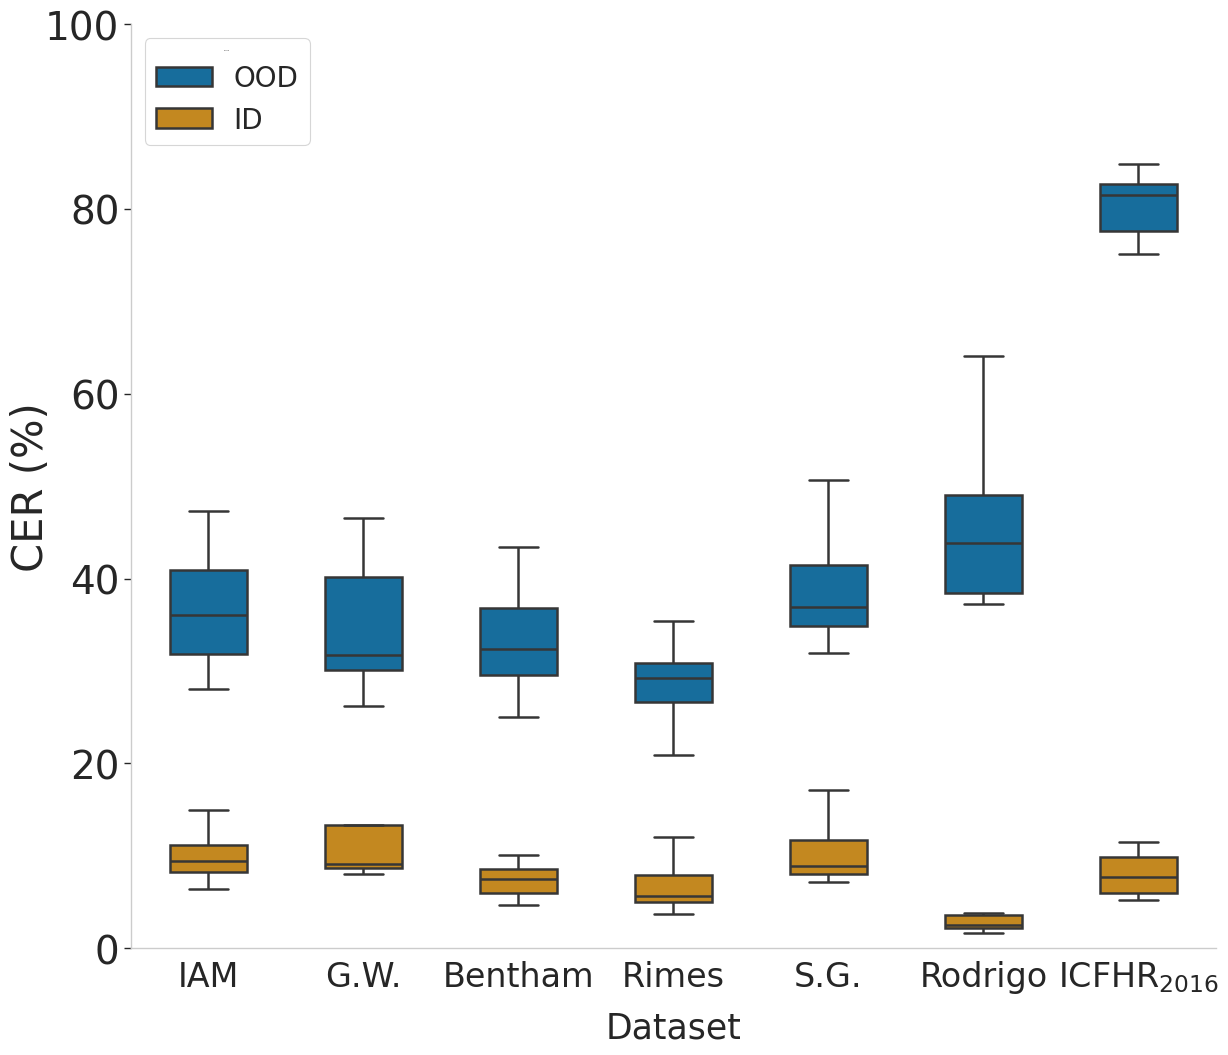

In [53]:
columns = ['Name', 'train_datasets', 'test/test_cer_iam', 'test/test_cer_washington', 'test/test_cer_bentham', 'test/test_cer_rimes', 'test/test_cer_saint_gall', 'test/test_cer_rodrigo', 'test/test_cer_icfhr_2016']


# pd_all
# pd_all = pd.read_csv('../results/preliminary_results.csv')
pd_all = pd.read_csv('../results/results_all_final.csv')
pd_all = pd_all[columns]

pd_all['train_datasets'] = pd_all['train_datasets'].apply(lambda x: x.removeprefix('[').removesuffix(']').split(',')[0])

# Apply the following dictionary to Name columns creating a new column called architecture removing before _src_ in name
pd_all['architecture'] = pd_all['Name'].apply(lambda x: x.split('_src_')[0])

# Drop if any of the columns contains a NaN value
# pd_all = pd_all.dropna()
pd_all = pd_all[['Name'] + ['architecture'] + columns[1:]]

# Melt the table to have each test/test_cer_{dataset} in a single column
pd_all = pd.melt(pd_all, id_vars=['Name', 'train_datasets', 'architecture'], value_vars=['test/test_cer_iam', 'test/test_cer_washington', 'test/test_cer_bentham', 'test/test_cer_rimes', 'test/test_cer_saint_gall', 'test/test_cer_rodrigo', 'test/test_cer_icfhr_2016'], var_name='test_dataset', value_name='CER')

# Remove test/test_cer_ from test_dataset
pd_all['test_dataset'] = pd_all['test_dataset'].apply(lambda x: x.removeprefix('test/test_cer_'))
pd_all['train_datasets'] = pd_all['train_datasets'].apply(lambda x: x.removeprefix('"').removesuffix('"')).astype(str)

print(pd_all['train_datasets'].unique())
print(pd_all['test_dataset'].unique())


# Create a new column called scenario with ID if train_datasets == test_dataset and OOD if train_datasets != test_dataset
pd_all['scenario'] = pd_all.apply(lambda x: 'ID' if x['train_datasets'] == x['test_dataset'] else 'OOD', axis=1)
pd_all['CER'] = pd_all['CER'] * 100
pd_all['CER'] = pd_all['CER'].apply(lambda x: min(x, 100))

# Drop  if scenario is ID and CER > 40
pd_all = pd_all[~((pd_all['scenario'] == 'ID') & (pd_all['CER'] > 40))]

sns.set_context("paper")
# sns.set_style("whitegrid")

fig, axs = plt.subplots(1, 1, figsize=(14, 12))

axs.set_ylim(0, 100)


# Filter to have per each test_dataset in OOD the best value 
pd_all = pd_all.groupby(['test_dataset', 'scenario', 'architecture']).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)

# Select only the best OOD value for each test_dataset for each architecture
pd_all_ood = pd_all[pd_all['scenario'] == 'OOD']
pd_all_id = pd_all[pd_all['scenario'] == 'ID']

# Filter if ID CER > 30
pd_all_id = pd_all_id[~(pd_all_id['CER'] > 30)]

# Clamp if ID CER > 30 to 35
# pd_all_id['CER'] = pd_all_id['CER'].apply(lambda x: min(x, 25))

pd_all_ood = pd_all_ood.groupby(['test_dataset', 'architecture'], group_keys=True).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)

# Concatenate both tables
pd_all = pd.concat([pd_all_ood, pd_all_id])
pd_all = pd_all.reset_index(drop=True)

# Sort results according to the test_dataset: ['iam', 'washington', 'bentham', 'rimes', 'saint_gall', 'rodrigo', 'icfhr_2016']
test_order = ['iam', 'washington', 'bentham', 'rimes', 'saint_gall', 'rodrigo', 'icfhr_2016']

pd_all['test_dataset'] = pd.Categorical(pd_all['test_dataset'], categories=test_order, ordered=True)
pd_all = pd_all.sort_values('test_dataset')
# Make a whisker plot for each test_dataset averaging the CER value for each architecture and scenario. Make the boxplot one above the other between ID and OOD
sns.boxplot(data=pd_all, x='test_dataset', y='CER', hue='scenario', ax=axs, linewidth=1.8, dodge=False, width=0.5, palette='colorblind', hue_order=['OOD', 'ID'], showfliers=False)



handles, labels = axs.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs.legend(by_label.values(), by_label.keys(), title='Scenario', loc='upper left', ncol=1, fontsize=20, title_fontsize=-1)
# Remove title from legend
# axs.get_legend().set_title('')


axs.set_xticklabels(['IAM', 'G.W.', 'Bentham', 'Rimes', 'S.G.', 'Rodrigo', 'ICFHR$_{2016}$'])
axs.set_yticks([0, 20, 40, 60, 80, 100], minor=True)

# Set yticks visible to the left
axs.yaxis.set_ticks_position('left')
# axs.xaxis.set_ticks_position('bottom')

axs.set_xlabel('Dataset', fontsize=25, labelpad=12)
axs.set_ylabel('CER (%)', fontsize=30, labelpad=-5)
# axs.set_title('CER for each test dataset', fontsize=30)


# Make y ticks bigger
plt.setp(axs.get_yticklabels(), fontsize=28)
plt.setp(axs.get_xticklabels(), fontsize=24)

# Invert boxplot colors


# Set the legend at the top and flatten horizontally just below the title


# Remove grid
axs.grid(False)

# Remove rectangle around the plot
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

# Save the figure in results with .pdf extension
plt.savefig('../results/ID_OOD.pdf', format='pdf', bbox_inches='tight')


In [3]:
pd_all = pd.read_csv('../results/results_all_final.csv')
pd_all = pd_all[columns]

pd_all['train_datasets'] = pd_all['train_datasets'].apply(lambda x: x.removeprefix('[').removesuffix(']').split(',')[0])

# Apply the following dictionary to Name columns creating a new column called architecture removing before _src_ in name
pd_all['architecture'] = pd_all['Name'].apply(lambda x: x.split('_src_')[0])

# Drop if any of the columns contains a NaN value
# pd_all = pd_all.dropna()
pd_all = pd_all[['Name'] + ['architecture'] + columns[1:]]

# Melt the table to have each test/test_cer_{dataset} in a single column
pd_all = pd.melt(pd_all, id_vars=['Name', 'train_datasets', 'architecture'], value_vars=['test/test_cer_iam', 'test/test_cer_washington', 'test/test_cer_bentham', 'test/test_cer_rimes', 'test/test_cer_saint_gall', 'test/test_cer_rodrigo', 'test/test_cer_icfhr_2016'], var_name='test_dataset', value_name='CER')


# # Remove test/test_cer_ from test_dataset
pd_all['test_dataset'] = pd_all['test_dataset'].apply(lambda x: x.removeprefix('test/test_cer_'))
pd_all['train_datasets'] = pd_all['train_datasets'].apply(lambda x: x.removeprefix('"').removesuffix('"')).astype(str)
# show(pd_all)

# # Create a new column called scenario with ID if train_datasets == test_dataset and OOD if train_datasets != test_dataset
pd_all['scenario'] = pd_all.apply(lambda x: 'ID' if x['train_datasets'] == x['test_dataset'] else 'OOD', axis=1)
pd_all['CER'] = pd_all['CER'] * 100

# # Cap the CER value to 100
pd_all['CER'] = pd_all['CER'].apply(lambda x: min(x, 100))

# # Drop  if scenario is ID and CER > 40
# # pd_all = pd_all[~((pd_all['scenario'] == 'ID') & (pd_all['CER'] > 40))]

# # Select only if ID in name
# # pd_all = pd_all[pd_all['Name'].str.contains('ID')]

pd_all_ood = pd_all[pd_all['scenario'] == 'OOD']
pd_all = pd_all_ood 

display(pd_all)
print(len(pd_all))
# print(len(pd_all_ood + pd_all_id))

Name train_datasets  \
0      crnn_michael_src_rimes_tgt_washington_test          rimes   
1      crnn_michael_src_rimes_tgt_saint_gall_test          rimes   
2         crnn_michael_src_rimes_tgt_rodrigo_test          rimes   
3      crnn_michael_src_rimes_tgt_icfhr_2016_test          rimes   
4             crnn_michael_src_rimes_tgt_iam_test          rimes   
...                                           ...            ...   
5035              light_barrere_src_rimes_ID_test          rimes   
5036  light_barrere_src_iam_optim_icfhr_2016_test            iam   
5037         light_barrere_src_iam_optim_iam_test            iam   
5038     light_barrere_src_iam_optim_bentham_test            iam   
5039                light_barrere_src_iam_ID_test            iam   

       architecture test_dataset        CER scenario  
0      crnn_michael          iam  54.830879      OOD  
1      crnn_michael          iam  54.830879      OOD  
2      crnn_michael          iam  54.830879      OOD  
3      crnn_michael          iam  54.545456      OOD  
4      crnn_michael          iam  54.830879      OOD  
...             ...          ...        ...      ...  
5035  light_barrere   icfhr_2016  90.473449      OOD  
5036  light_barrere   icfhr_2016  87.780333      OOD  
5037  light_barrere   icfhr_2016  98.059231      OOD  
5038  light_barrere   icfhr_2016  94.263947      OOD  
5039  light_barrere   icfhr_2016  98.059231      OOD  

[4320 rows x 6 columns]

4320


In [4]:
# show where train_datasets == 'iam' and test_dataset == 'rimes'
show(pd_all[(pd_all['train_datasets'] == 'iam') & (pd_all['test_dataset'] == 'rimes')])

In [5]:
# Count number of entries per architecture
pd_all_ood.groupby('architecture').count()


Name  train_datasets  test_dataset  CER  scenario
architecture                                                       
cnn_san_arce       492             492           492  492       492
crnn_michael       534             534           534  534       534
crnn_puig          504             504           504  504       504
htr_vit            588             588           588  588       588
light_barrere      588             588           588  588       588
transformer_kang   588             588           588  588       588
v_light_barrere    540             540           540  540       540
van_coquenet       486             486           486  486       486

In [6]:
print(pd_all['architecture'].unique())

['crnn_michael' 'crnn_puig' 'transformer_kang' 'htr_vit' 'light_barrere'
 'van_coquenet' 'v_light_barrere' 'cnn_san_arce']


## Model selection results

In [7]:
# Separate according to the scenario. if Name contains tgt: model_selection=oracle, if Name contains tgt: model_selection=heldout,  If Name does not contain any of the previous: model_selection=no-selection
pd_all['model_selection'] = pd_all['Name'].apply(lambda x: 'oracle' if 'optim' in x else 'heldout' if 'tgt' in x else 'no-selection')
display(pd_all)



# model selection is oracle only if the model is trained with the same dataset as the test dataset

Name train_datasets  \
0      crnn_michael_src_rimes_tgt_washington_test          rimes   
1      crnn_michael_src_rimes_tgt_saint_gall_test          rimes   
2         crnn_michael_src_rimes_tgt_rodrigo_test          rimes   
3      crnn_michael_src_rimes_tgt_icfhr_2016_test          rimes   
4             crnn_michael_src_rimes_tgt_iam_test          rimes   
...                                           ...            ...   
5035              light_barrere_src_rimes_ID_test          rimes   
5036  light_barrere_src_iam_optim_icfhr_2016_test            iam   
5037         light_barrere_src_iam_optim_iam_test            iam   
5038     light_barrere_src_iam_optim_bentham_test            iam   
5039                light_barrere_src_iam_ID_test            iam   

       architecture test_dataset        CER scenario model_selection  
0      crnn_michael          iam  54.830879      OOD         heldout  
1      crnn_michael          iam  54.830879      OOD         heldout  
2      crnn_michael          iam  54.830879      OOD         heldout  
3      crnn_michael          iam  54.545456      OOD         heldout  
4      crnn_michael          iam  54.830879      OOD         heldout  
...             ...          ...        ...      ...             ...  
5035  light_barrere   icfhr_2016  90.473449      OOD    no-selection  
5036  light_barrere   icfhr_2016  87.780333      OOD          oracle  
5037  light_barrere   icfhr_2016  98.059231      OOD          oracle  
5038  light_barrere   icfhr_2016  94.263947      OOD          oracle  
5039  light_barrere   icfhr_2016  98.059231      OOD    no-selection  

[4320 rows x 7 columns]

In [8]:
pd_all['dataset_selection'] = pd_all['Name'].apply(lambda x: x.split('_test')[0].split('_tgt_')[1] if 'tgt' in x else x.split('_test')[0].split('_optim_')[1] if 'optim' in x else 'no-selection')
pd_all['dataset_selection'] = pd_all['dataset_selection'].apply(lambda x: x.removeprefix('"').removesuffix('"')).astype(str)


# Filter only if model_selection is heldout or oracle and dataset_selection is different is test_dataset
pd_all_selection = pd_all[(pd_all['model_selection'] == 'heldout') | (pd_all['model_selection'] == 'oracle')]

# Calculate oracle results in pd_all_oracle

In [9]:

# oracle only if model_selecion is oracle and dataset_selection is equal to test_dataset
pd_all_oracle = pd_all_selection[(pd_all_selection['model_selection'] == 'oracle')] #& (pd_all_selection['dataset_selection'] == pd_all_selection['test_dataset'])]
print(f'Oracle: {len(pd_all_oracle)}')
show(pd_all_oracle)

# Get oracle min results per arquitecture and test_dataset
pd_all_oracle = pd_all_oracle.groupby(['architecture', 'test_dataset']).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)
print(f'Grouped results Oracle: {len(pd_all_oracle)}')
show(pd_all_oracle)

show(pd_all_oracle.groupby('architecture').describe())

# Get the mean of the oracle results per architecture
pd_all_oracle = pd_all_oracle.groupby('architecture').mean().reset_index()
print(f'Mean results Oracle: {len(pd_all_oracle)}')
show(pd_all_oracle)

Oracle: 2112


Grouped results Oracle: 56


Mean results Oracle: 8


/tmp/ipykernel_1719094/470424463.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_all_oracle = pd_all_oracle.groupby('architecture').mean().reset_index()


In [10]:
# Calculate heldout results in pd_all_heldout
pd_all_heldout = pd_all_selection[(pd_all_selection['model_selection'] == 'heldout' ) & (pd_all_selection['dataset_selection'] == pd_all_selection['test_dataset'])]
print(f'Heldout: {len(pd_all_heldout)}')
show(pd_all_heldout)

# Get heldout min results per arquitecture and test_dataset
pd_all_heldout = pd_all_heldout.groupby(['architecture', 'test_dataset']).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)
print(f'Grouped results Heldout: {len(pd_all_heldout)}')
show(pd_all_heldout)

show(pd_all_heldout.groupby('architecture').describe())

# Get the mean of the oracle results per architecture
pd_all_heldout = pd_all_heldout.groupby('architecture').mean().reset_index()
print(f'Mean results Heldout: {len(pd_all_heldout)}')
show(pd_all_heldout)





Heldout: 310


Grouped results Heldout: 56


Mean results Heldout: 8


/tmp/ipykernel_1719094/2921291625.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_all_heldout = pd_all_heldout.groupby('architecture').mean().reset_index()


In [11]:
# Finally select where model_selection is no-selection
pd_all_no_selection = pd_all[pd_all['model_selection'] == 'no-selection']
print(f'No selection: {len(pd_all_no_selection)}')
show(pd_all_no_selection)

# Get no-selection min results per arquitecture and test_dataset
pd_all_no_selection = pd_all_no_selection.groupby(['architecture', 'test_dataset']).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)
print(f'Grouped results No selection: {len(pd_all_no_selection)}')
show(pd_all_no_selection)

show(pd_all_no_selection.groupby('architecture').describe())

# Get the mean of the oracle results per architecture
pd_all_no_selection = pd_all_no_selection.groupby('architecture').mean().reset_index()
print(f'Mean results No selection: {len(pd_all_no_selection)}')
show(pd_all_no_selection)


No selection: 336


Grouped results No selection: 56


Mean results No selection: 8


/tmp/ipykernel_1719094/2778415404.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_all_no_selection = pd_all_no_selection.groupby('architecture').mean().reset_index()


In [12]:
# Put all together adding a new column called model_selection with the value of the model selection
# Show the three results in a single table
pd_all_selections = pd.DataFrame()
pd_all_oracle['model_selection'] = 'oracle'
pd_all_heldout['model_selection'] = 'heldout'
pd_all_no_selection['model_selection'] = 'no-selection'

# Concatenate the three where the new columns are the name of the model selection
pd_all_selections = pd.concat([pd_all_oracle, pd_all_heldout, pd_all_no_selection], axis=0)
pd_all_selections = pd_all_selections.reset_index(drop=True)
show(pd_all_selections)

# Separate results in three columns: oracle, heldout, no-selection
pd_all_selections = pd_all_selections.pivot(index='architecture', columns='model_selection', values='CER').reset_index()
show(pd_all_selections)

# show(pd_all_oracle)
# show(pd_all_heldout)
# show(pd_all_no_selection)

# add a column best wich the model selection with the lowest CER
pd_all_selections['best'] = pd_all_selections[['oracle', 'heldout', 'no-selection']].idxmin(axis=1)
pd_all_selections['second_best'] = pd_all_selections[['oracle', 'heldout', 'no-selection']].apply(lambda x: x.drop(x.idxmin()).idxmin(), axis=1)
show(pd_all_selections)

# Exclude best and second best from the table
pd_all_grouped = pd_all_selections.drop(columns=['best', 'second_best'])

In [13]:
# # For each model selection, select the best OOD obtained for each test_dataset and architecture
# pd_all_grouped = pd_all[pd_all['scenario'] == 'OOD'].groupby(['test_dataset', 'scenario', 'architecture', 'model_selection']).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)
# show(pd_all_grouped)

# # # Get the average CER grouping by architecture and model_selection
# pd_all_grouped_avg = pd_all_grouped.groupby(['architecture', 'model_selection']).mean().reset_index()
# # pd_all_grouped_avg

# # Get the relative difference between oracle and heldout with respect to no-selection
# # pd_all_grouped_avg['relative_diff'] = pd_all_grouped_avg.groupby('architecture').apply(lambda x: x['CER'].diff().shift(-1)).reset_index(drop=True)
# # pd_all_grouped_avg

# # Convert each model selection to a column for each architecture
# pd_all_grouped_avg = pd_all_grouped_avg.pivot(index='architecture', columns='model_selection', values='CER').reset_index()
# pd_all_grouped_avg.columns = ['architecture', 'heldout', 'no-selection', 'oracle']
# # pd_all_grouped_avg



In [14]:
display(pd_all_grouped)
pd_all_grouped_avg = pd_all_grouped
display(pd_all_grouped_avg)

model_selection      architecture    heldout  no-selection     oracle
0                    cnn_san_arce  45.147272     44.808954  43.637009
1                    crnn_michael  53.526777     53.925140  52.974938
2                       crnn_puig  41.705806     38.493606  36.840830
3                         htr_vit  41.625308     41.208213  39.140033
4                   light_barrere  44.764294     45.060368  43.075232
5                transformer_kang  50.668491     51.777697  48.462502
6                 v_light_barrere  43.735055     43.912387  42.482505
7                    van_coquenet  37.763388     37.426399  36.294320

model_selection      architecture    heldout  no-selection     oracle
0                    cnn_san_arce  45.147272     44.808954  43.637009
1                    crnn_michael  53.526777     53.925140  52.974938
2                       crnn_puig  41.705806     38.493606  36.840830
3                         htr_vit  41.625308     41.208213  39.140033
4                   light_barrere  44.764294     45.060368  43.075232
5                transformer_kang  50.668491     51.777697  48.462502
6                 v_light_barrere  43.735055     43.912387  42.482505
7                    van_coquenet  37.763388     37.426399  36.294320

(30.0, 70.0)

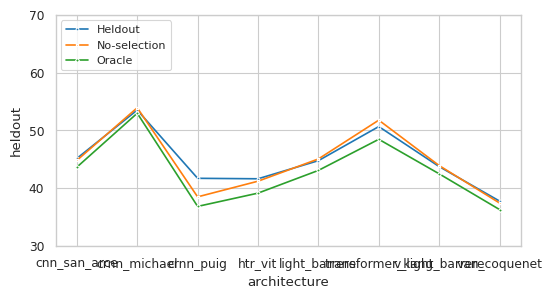

In [15]:
# Make a plot with 3 lines, one for each model selection, with the average CER for each architecture from pd_all_grouped_avg
sns.set_context("paper")
sns.set_style("whitegrid")

fig, axs = plt.subplots(1, 1, figsize=(6, 3))

# Make the markers bigger
# Order the x axis as iam, washington, bentham, rimes, saint_gall, rodrigo, icfhr_2016 and change the labels to be capitalized

# Make a line plot for each model selection
sns.lineplot(data=pd_all_grouped_avg, x='architecture', y='heldout', ax=axs, marker='o', markersize=2, label='Heldout', color='tab:blue')
sns.lineplot(data=pd_all_grouped_avg, x='architecture', y='no-selection', ax=axs, marker='X', markersize=2, label='No-selection', color='tab:orange')
sns.lineplot(data=pd_all_grouped_avg, x='architecture', y='oracle', ax=axs, marker='D', markersize=2, label='Oracle', color='tab:green')

# Set the legend at the top and flatten horizontally just below the title
handles, labels = axs.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs.legend(by_label.values(), by_label.keys(), title='Model selection', loc='upper left', ncol=1, fontsize=8, title_fontsize=-1)
# Remove title from legend
axs.get_legend().set_title('')
axs.set_yticks(np.arange(0, 101, 10))
# axs.set_yticks([0, 10, 30, 50, 70, 90, 100])

axs.set_ylim(30, 70)



In [16]:
# Calculate the relative difference between oracle and heldout with respect to no-selection
pd_all_grouped_avg['relative_diff_oracle'] = (pd_all_grouped_avg['no-selection'] - pd_all_grouped_avg['oracle']) / pd_all_grouped_avg['oracle'] * 100 
pd_all_grouped_avg['relative_diff_heldout'] = (pd_all_grouped_avg['no-selection'] - pd_all_grouped_avg['heldout']) / pd_all_grouped_avg['heldout'] * 100

# Reformat the table to have the relative difference for each model selection (relative_diff_oracle and relative_diff_heldout) in a single column
pd_all_grouped_avg_melted = pd_all_grouped_avg.melt(id_vars='architecture', value_vars=['relative_diff_oracle', 'relative_diff_heldout'], var_name='model_selection', value_name='relative_diff')
display(pd_all_grouped_avg_melted)

# Rename the model_selection values eliminating the prefix relative_diff_
pd_all_grouped_avg_melted['model_selection'] = pd_all_grouped_avg_melted['model_selection'].apply(lambda x: x.removeprefix('relative_diff_'))
display(pd_all_grouped_avg_melted)

# map architecture name

architectures_names =  dict({
  'v_light_barrere': 'VLT', 'van_coquenet': 'VAN', 'transformer_kang': 'Kang', 'cnn_san_arce': 'C-SAN',
  'light_barrere': 'LT', 'htr_vit': 'HTR-VIT', 'crnn_puig': 'CRNN', 'crnn_michael': 'Michael'
})

pd_all_grouped_avg_melted['architecture'] = pd_all_grouped_avg_melted['architecture'].map(architectures_names)
display(pd_all_grouped_avg_melted)


architecture        model_selection  relative_diff
0       cnn_san_arce   relative_diff_oracle       2.685668
1       crnn_michael   relative_diff_oracle       1.793682
2          crnn_puig   relative_diff_oracle       4.486262
3            htr_vit   relative_diff_oracle       5.284051
4      light_barrere   relative_diff_oracle       4.608532
5   transformer_kang   relative_diff_oracle       6.840742
6    v_light_barrere   relative_diff_oracle       3.365814
7       van_coquenet   relative_diff_oracle       3.119164
8       cnn_san_arce  relative_diff_heldout      -0.749365
9       crnn_michael  relative_diff_heldout       0.744231
10         crnn_puig  relative_diff_heldout      -7.702044
11           htr_vit  relative_diff_heldout      -1.002024
12     light_barrere  relative_diff_heldout       0.661407
13  transformer_kang  relative_diff_heldout       2.189143
14   v_light_barrere  relative_diff_heldout       0.405470
15      van_coquenet  relative_diff_heldout      -0.892369

architecture model_selection  relative_diff
0       cnn_san_arce          oracle       2.685668
1       crnn_michael          oracle       1.793682
2          crnn_puig          oracle       4.486262
3            htr_vit          oracle       5.284051
4      light_barrere          oracle       4.608532
5   transformer_kang          oracle       6.840742
6    v_light_barrere          oracle       3.365814
7       van_coquenet          oracle       3.119164
8       cnn_san_arce         heldout      -0.749365
9       crnn_michael         heldout       0.744231
10         crnn_puig         heldout      -7.702044
11           htr_vit         heldout      -1.002024
12     light_barrere         heldout       0.661407
13  transformer_kang         heldout       2.189143
14   v_light_barrere         heldout       0.405470
15      van_coquenet         heldout      -0.892369

architecture model_selection  relative_diff
0         C-SAN          oracle       2.685668
1       Michael          oracle       1.793682
2          CRNN          oracle       4.486262
3       HTR-VIT          oracle       5.284051
4            LT          oracle       4.608532
5          Kang          oracle       6.840742
6           VLT          oracle       3.365814
7           VAN          oracle       3.119164
8         C-SAN         heldout      -0.749365
9       Michael         heldout       0.744231
10         CRNN         heldout      -7.702044
11      HTR-VIT         heldout      -1.002024
12           LT         heldout       0.661407
13         Kang         heldout       2.189143
14          VLT         heldout       0.405470
15          VAN         heldout      -0.892369

/tmp/ipykernel_1719094/801657838.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
/tmp/ipykernel_1719094/801657838.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=14)


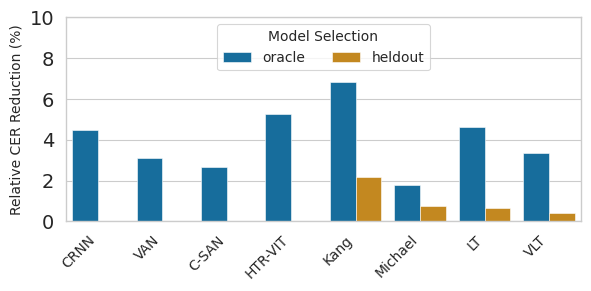

In [17]:
# Make a plot with the average CER for each architecture and model_selection
sns.set_context("paper")
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Set the y-axis limit
ax.set_ylim(0, 10)

# Create the bar plot with 'architecture' on x-axis and 'relative_diff' on y-axis, hue by 'model_selection'

# Change x order to: ['CRNN', 'VAN', 'C-SAN', 'HTR_VIT', 'Kang', 'Michael', 'LT', 'VLT']
pd_all_grouped_avg_melted['architecture'] = pd.Categorical(pd_all_grouped_avg_melted['architecture'], categories=['CRNN', 'VAN', 'C-SAN', 'HTR-VIT', 'Kang', 'Michael', 'LT', 'VLT'], ordered=True)
sns.barplot(data=pd_all_grouped_avg_melted, x='architecture', y='relative_diff', hue='model_selection', ax=ax, palette='colorblind', linewidth=0.4) 


# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)

# Set axis labels and title
# ax.set_xlabel("Architecture", fontsize=12)
# Remove x label
ax.set_xlabel('')
ax.set_ylabel("Relative CER Reduction (%)", fontsize=10)
ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=14)
# ax.set_title("Average CER Reduction by Architecture and Model Selection", fontsize=14)

# Adjust the legend position and title
ax.legend(title="Model Selection", loc='upper center', fontsize=10, ncols=2, title_fontsize=10)

# Add tight layout for better spacing
plt.tight_layout()

# Save the figure in results with .pdf extension
plt.savefig('../results/model_selection.pdf', format='pdf', bbox_inches='tight')


In [18]:
# pd_all_grouped_avg_params

/tmp/ipykernel_1719094/2388600197.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='no-selection', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='No-selection')
/tmp/ipykernel_1719094/2388600197.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='oracle', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='Oracle', linestyle='--')
/tmp/ipykernel_1719094/2388600197.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='heldout', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='Heldout', linestyle=':')
/tmp/ipykernel_1719094/2388600197.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}'.f

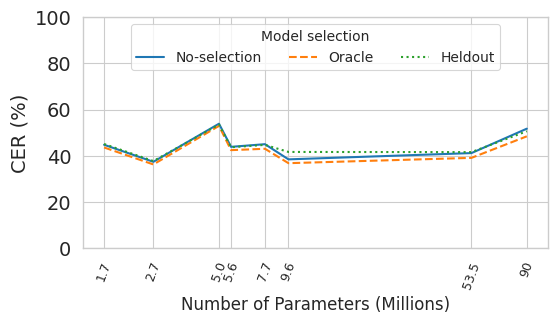

In [19]:
sns.set_context("paper")
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Set the y-axis limit
ax.set_ylim(0, 100)

pd_all_grouped_avg_params = pd_all_grouped_avg.copy()
pd_all_grouped_avg_params['n_parameters'] = pd_all_grouped_avg_melted['architecture'].apply(lambda x: 9.6 if x == 'CRNN' else 2.7 if x == 'VAN' else 1.7 if x == 'C-SAN' else 53.5 if x == 'HTR-VIT' else 90 if x == 'Kang' else 5 if x == 'Michael' else 7.7 if x == 'LT' else 5.6 if x == 'VLT' else 0.0)
# pd_all_grouped_avg_params

show(pd_all_grouped_avg_params)

# Make a line plot with the average CER for each architecture sorted by number of parameters
pd_all_grouped_avg_params = pd_all_grouped_avg_params.sort_values('n_parameters')
# pd_all_grouped_avg_params['CER'] = pd_all_grouped_avg_params['no-selection']

# sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='no-selection', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='No-selection')
# sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='oracle', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='Oracle')
# sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='heldout', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='Heldout')

# Set line solid for no-selection, dashed for oracle and dotted for heldout
sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='no-selection', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='No-selection')
sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='oracle', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='Oracle', linestyle='--')
sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='heldout', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='Heldout', linestyle=':')


# ax.set_ylim(30, 65)
# ax.set_yticks([30, 40, 50, 60])

ax.set_xscale('log')

ax.set_xticks([1.7, 2.7, 5, 5.6, 7.7, 9.6, 53.5, 90])
ax.set_xticklabels(['1.7', '2.7', '5.0', '5.6', '7.7', '9.6', '53.5', '90'], fontsize=9, rotation=70)

# ax.set_xticks([1.7, 3, 5, 7, 10, 50, 90])
# ax.set_xticklabels(['1.7', '3', '5', '7', '10', '50', '90'], fontsize=9, rotation=0)

# Write every parameter as text
# for i, txt in enumerate(pd_all_grouped_avg_params['architecture']):
#     ax.annotate(txt, (pd_all_grouped_avg_params['n_parameters'][i], pd_all_grouped_avg_params['no-selection'][i]), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=9)

# Set axis labels and title
ax.set_xlabel("Number of Parameters (Millions)", fontsize=12)
ax.set_ylabel("CER (%)", fontsize=14)
ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=14)

# Set legend
# ax.legend(title="Model Selection", loc='upper center', fontsize=10, title_fontsize=10)
# legend_labels = ['No-selection', 'Oracle', 'Heldout']
# colors = sns.color_palette('colorblind')
ax.legend(title="Model selection", loc='upper center', fontsize=10, title_fontsize=10, ncol=3)

# Save the figure in results with .pdf extension
plt.savefig('../results/parameters_2.pdf', format='pdf', bbox_inches='tight')


architecture model_selection  relative_diff n_parameters
0         C-SAN          oracle       2.685668          1.7
1       Michael          oracle       1.793682          5.0
2          CRNN          oracle       4.486262          9.6
3       HTR-VIT          oracle       5.284051         53.5
4            LT          oracle       4.608532          7.7
5          Kang          oracle       6.840742         90.0
6           VLT          oracle       3.365814          5.6
7           VAN          oracle       3.119164          2.7
8         C-SAN         heldout      -0.749365          1.7
9       Michael         heldout       0.744231          5.0
10         CRNN         heldout      -7.702044          9.6
11      HTR-VIT         heldout      -1.002024         53.5
12           LT         heldout       0.661407          7.7
13         Kang         heldout       2.189143         90.0
14          VLT         heldout       0.405470          5.6
15          VAN         heldout      -0.892369          2.7

/tmp/ipykernel_1719094/256357542.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=14)


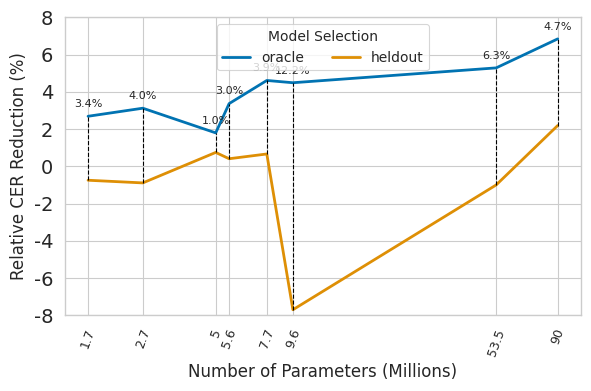

In [20]:
# Add the following number of parameters to each architecture: 
# Puigcerver: 9.6M, VAN Coquenet: 2.7M, C-SAN-Arce: 1.7M, HTR-VIT: 53.5M, Kang: 90M, TrOCR: 62M, Michael: 8M, LT: 7.7M, VLT: 5.6M as float
pd_all_grouped_avg_melted['n_parameters'] = pd_all_grouped_avg_melted['architecture'].apply(lambda x: 9.6 if x == 'CRNN' else 2.7 if x == 'VAN' else 1.7 if x == 'C-SAN' else 53.5 if x == 'HTR-VIT' else 90 if x == 'Kang' else 5 if x == 'Michael' else 7.7 if x == 'LT' else 5.6 if x == 'VLT' else 0.0)
display(pd_all_grouped_avg_melted)

# Make a plot with the average CER for each model selection and number of parameters in the x-axis
sns.set_context("paper")
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Set the y-axis limit
ax.set_ylim(-8, 8)

# Create a line plot with 'n_parameters' on x-axis and 'relative_diff' on y-axis, hue by 'model_selection'
sns.lineplot(data=pd_all_grouped_avg_melted, x='n_parameters', y='relative_diff', hue='model_selection', ax=ax, palette='colorblind', linewidth=2)

# Set the x axis to other scale
ax.set_xscale('log')

ax.set_xticks([1.7, 2.7, 5, 5.6, 7.7, 9.6, 53.5, 90])
ax.set_xticklabels(['1.7', '2.7', '5', '5.6', '7.7', '9.6', '53.5', '90'], fontsize=9, rotation=70)

# Make a vertical line measuring the absolute difference between oracle and heldout with respect to no-selection with annotated difference in each point
for i, row in pd_all_grouped_avg_params.iterrows():
  diff = row['relative_diff_oracle'] - row['relative_diff_heldout']
  ax.plot([row['n_parameters'], row['n_parameters']], [row['relative_diff_heldout'], row['relative_diff_oracle']], linestyle='--', color='black', linewidth=0.8)
  ax.text(row['n_parameters'], row['relative_diff_oracle'] + 0.5, f"{np.round(diff, 1):.1f}%", fontsize=8, ha='center')
  
  
    

# Add text to the vertical line


# Set axis labels and title
ax.set_xlabel("Number of Parameters (Millions)", fontsize=12)
ax.set_ylabel("Relative CER Reduction (%)", fontsize=12)


ax.set_ylabel("Relative CER Reduction (%)", fontsize=12)
ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=14)

# Adjust the legend position and title
# ax.legend(title="Model Selection", loc='upper center', fontsize=10, title_fontsize=10)
ax.legend(title="Model Selection", loc='upper center', fontsize=10, ncols=2, title_fontsize=10)

# make a legend for vertical line
# ax.plot([], [], linestyle='--', color='black', linewidth=0.8, label='|Oracle - Heldout|')
# ax.legend(title="Model Selection", loc='upper center', fontsize=10, ncols=2, title_fontsize=10)

# Add tight layout for better spacing
plt.tight_layout()

# Save the figure in results with .pdf extension
plt.savefig('../results/parameters.pdf', format='pdf', bbox_inches='tight')


## Synthetic results

In [21]:
# Repeat no-selection, oracle and heldout using synthetic data. In this case there are 3 architectures: CRNN, VAN and C-SAN and oracle and heldout 

pd_synthetic = pd.read_csv('../results/results_synth_final.csv')
pd_synthetic = pd_synthetic[columns]
display(pd_synthetic)

pd_synthetic['train_datasets'] = pd_synthetic['train_datasets'].apply(lambda x: x.removeprefix('[').removesuffix(']').split(',')[0])

# Apply the following dictionary to Name columns creating a new column called architecture removing before _src_ in name
pd_synthetic['architecture'] = pd_synthetic['Name'].apply(lambda x: x.split('_src_')[0])

# Drop if any of the columns contains a NaN value

pd_synthetic = pd_synthetic[['Name'] + ['architecture'] + columns[1:]]
# Melt the table to have each test/test_cer_{dataset} in a single column
pd_synthetic = pd.melt(pd_synthetic, id_vars=['Name', 'train_datasets', 'architecture'], value_vars=['test/test_cer_iam', 'test/test_cer_washington', 'test/test_cer_bentham', 'test/test_cer_rimes', 'test/test_cer_saint_gall', 'test/test_cer_rodrigo', 'test/test_cer_icfhr_2016'], var_name='test_dataset', value_name='CER')

# Remove test/test_cer_ from test_dataset
pd_synthetic['test_dataset'] = pd_synthetic['test_dataset'].apply(lambda x: x.removeprefix('test/test_cer_'))
pd_synthetic['train_datasets'] = pd_synthetic['train_datasets'].apply(lambda x: x.removeprefix('"').removesuffix('"')).astype(str)

# Create a new column called scenario with ID if train_datasets == test_dataset and OOD if train_datasets != test_dataset
pd_synthetic['scenario'] = pd_synthetic.apply(lambda x: 'ID' if x['train_datasets'] == x['test_dataset'] else 'OOD', axis=1)
pd_synthetic['CER'] = pd_synthetic['CER'] * 100

# Cap the CER value to 100
pd_synthetic['CER'] = pd_synthetic['CER'].apply(lambda x: min(x, 100))
pd_synthetic_ood = pd_synthetic[pd_synthetic['scenario'] == 'OOD']
pd_synthetic = pd_synthetic_ood

display(pd_synthetic)



Name train_datasets  \
0             light_barrere_src_wit_en_tgt_iam_test     ["wit_en"]   
1    light_barrere_src_wit_en_optim_saint_gall_test     ["wit_en"]   
2       light_barrere_src_wit_en_optim_rodrigo_test     ["wit_en"]   
3         light_barrere_src_wit_en_optim_rimes_test     ["wit_en"]   
4       light_barrere_src_wit_en_optim_bentham_test     ["wit_en"]   
..                                              ...            ...   
565           crnn_puig_src_wit_en_optim_rimes_test     ["wit_en"]   
566      crnn_puig_src_wit_en_optim_icfhr_2016_test     ["wit_en"]   
567             crnn_puig_src_wit_en_optim_iam_test     ["wit_en"]   
568         crnn_puig_src_wit_en_optim_bentham_test     ["wit_en"]   
569                    crnn_puig_src_wit_en_ID_test     ["wit_en"]   

     test/test_cer_iam  test/test_cer_washington  test/test_cer_bentham  \
0             0.145845                  0.156854               0.216255   
1             0.138152                  0.153894               0.227550   
2             0.147469                  0.168847               0.234902   
3             0.142212                  0.162617               0.234037   
4             0.141178                  0.163551               0.213712   
..                 ...                       ...                    ...   
565           0.121116                  0.170093               0.207632   
566           0.128572                  0.203583               0.221598   
567           0.118631                  0.176324               0.209387   
568                NaN                       NaN                    NaN   
569           0.366909                  0.438318               0.477232   

     test/test_cer_rimes  test/test_cer_saint_gall  test/test_cer_rodrigo  \
0               0.264459                  0.251920               0.289457   
1               0.254735                  0.233705               0.281626   
2               0.266160                  0.246403               0.279580   
3               0.250567                  0.244415               0.285128   
4               0.257541                  0.235842               0.277797   
..                   ...                       ...                    ...   
565             0.222755                  0.266829               0.279686   
566             0.238121                  0.283105               0.293746   
567             0.222131                  0.276595               0.288219   
568                  NaN                       NaN                    NaN   
569             0.488291                  0.481674               0.485749   

     test/test_cer_icfhr_2016  
0                    0.805683  
1                    0.833860  
2                    0.864386  
3                    0.875503  
4                    0.848764  
..                        ...  
565                  0.813159  
566                  0.785221  
567                  0.780813  
568                       NaN  
569                  0.861463  

[570 rows x 9 columns]

Name train_datasets  \
0              light_barrere_src_wit_en_tgt_iam_test         wit_en   
1     light_barrere_src_wit_en_optim_saint_gall_test         wit_en   
2        light_barrere_src_wit_en_optim_rodrigo_test         wit_en   
3          light_barrere_src_wit_en_optim_rimes_test         wit_en   
4        light_barrere_src_wit_en_optim_bentham_test         wit_en   
...                                              ...            ...   
3985           crnn_puig_src_wit_en_optim_rimes_test         wit_en   
3986      crnn_puig_src_wit_en_optim_icfhr_2016_test         wit_en   
3987             crnn_puig_src_wit_en_optim_iam_test         wit_en   
3988         crnn_puig_src_wit_en_optim_bentham_test         wit_en   
3989                    crnn_puig_src_wit_en_ID_test         wit_en   

       architecture test_dataset        CER scenario  
0     light_barrere          iam  14.584495      OOD  
1     light_barrere          iam  13.815163      OOD  
2     light_barrere          iam  14.746891      OOD  
3     light_barrere          iam  14.221154      OOD  
4     light_barrere          iam  14.117812      OOD  
...             ...          ...        ...      ...  
3985      crnn_puig   icfhr_2016  81.315893      OOD  
3986      crnn_puig   icfhr_2016  78.522140      OOD  
3987      crnn_puig   icfhr_2016  78.081274      OOD  
3988      crnn_puig   icfhr_2016        NaN      OOD  
3989      crnn_puig   icfhr_2016  86.146253      OOD  

[3990 rows x 6 columns]

In [22]:
# Separate according to the scenario. if Name contains tgt: model_selection=oracle, if Name contains tgt: model_selection=heldout,  If Name does not contain any of the previous: model_selection=no-selection

pd_synthetic['model_selection'] = pd_synthetic['Name'].apply(lambda x: 'oracle' if 'optim' in x else 'heldout' if 'tgt' in x else 'no-selection')
# Delete no-selection
pd_synthetic = pd_synthetic[pd_synthetic['model_selection'] != 'no-selection']
display(pd_synthetic)

pd_synthetic['dataset_selection'] = pd_synthetic['Name'].apply(lambda x: x.split('_test')[0].split('_tgt_')[1] if 'tgt' in x else x.split('_test')[0].split('_optim_')[1] if 'optim' in x else 'no-selection')
pd_synthetic['dataset_selection'] = pd_synthetic['dataset_selection'].apply(lambda x: x.removeprefix('"').removesuffix('"')).astype(str)

# Filter only if model_selection is heldout or oracle and dataset_selection is different is test_dataset
pd_synthetic_selection = pd_synthetic[(pd_synthetic['model_selection'] == 'heldout') | (pd_synthetic['model_selection'] == 'oracle')]
display(pd_synthetic_selection)

# Calculate oracle results in pd_synthetic_oracle
pd_synthetic_oracle = pd_synthetic_selection[(pd_synthetic_selection['model_selection'] == 'oracle')] #& (pd_synthetic_selection['dataset_selection'] == pd_synthetic_selection['test_dataset'])]
print(f'Oracle: {len(pd_synthetic_oracle)}')
show(pd_synthetic_oracle)

# Get oracle min results per arquitecture and test_dataset
pd_synthetic_oracle = pd_synthetic_oracle.groupby(['architecture', 'test_dataset']).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)
print(f'Grouped results Oracle: {len(pd_synthetic_oracle)}')

show(pd_synthetic_oracle.groupby('architecture').describe())

# Get the mean of the oracle results per architecture
pd_synthetic_oracle = pd_synthetic_oracle.groupby('architecture').mean().reset_index()
print(f'Mean results Oracle: {len(pd_synthetic_oracle)}')
show(pd_synthetic_oracle)

# Calculate heldout results in pd_synthetic_heldout
pd_synthetic_heldout = pd_synthetic_selection[(pd_synthetic_selection['model_selection'] == 'heldout' ) & (pd_synthetic_selection['dataset_selection'] == pd_synthetic_selection['test_dataset'])]
print(f'Heldout: {len(pd_synthetic_heldout)}')
show(pd_synthetic_heldout)

# Get heldout min results per arquitecture and test_dataset
pd_synthetic_heldout = pd_synthetic_heldout.groupby(['architecture', 'test_dataset']).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)
print(f'Grouped results Heldout: {len(pd_synthetic_heldout)}')
show(pd_synthetic_heldout)

show(pd_synthetic_heldout.groupby('architecture').describe())

# Get the mean of the oracle results per architecture
pd_synthetic_heldout = pd_synthetic_heldout.groupby('architecture').mean().reset_index()
print(f'Mean results Heldout: {len(pd_synthetic_heldout)}')
show(pd_synthetic_heldout)

# Put all together adding a new column called model_selection with the value of the model selection
# Show the three results in a single table
pd_synthetic_selections = pd.DataFrame()
pd_synthetic_oracle['model_selection'] = 'oracle'
pd_synthetic_heldout['model_selection'] = 'heldout'

# Concatenate the three where the new columns are the name of the model selection
pd_synthetic_selections = pd.concat([pd_synthetic_oracle, pd_synthetic_heldout], axis=0)
pd_synthetic_selections = pd_synthetic_selections.reset_index(drop=True)
show(pd_synthetic_selections)

# Separate results in three columns: oracle, heldout, no-selection
pd_synthetic_selections = pd_synthetic_selections.pivot(index='architecture', columns='model_selection', values='CER').reset_index()
show(pd_synthetic_selections)

# show(pd_synthetic_oracle)


Name train_datasets  \
0              light_barrere_src_wit_en_tgt_iam_test         wit_en   
1     light_barrere_src_wit_en_optim_saint_gall_test         wit_en   
2        light_barrere_src_wit_en_optim_rodrigo_test         wit_en   
3          light_barrere_src_wit_en_optim_rimes_test         wit_en   
4        light_barrere_src_wit_en_optim_bentham_test         wit_en   
...                                              ...            ...   
3984         crnn_puig_src_wit_en_optim_rodrigo_test         wit_en   
3985           crnn_puig_src_wit_en_optim_rimes_test         wit_en   
3986      crnn_puig_src_wit_en_optim_icfhr_2016_test         wit_en   
3987             crnn_puig_src_wit_en_optim_iam_test         wit_en   
3988         crnn_puig_src_wit_en_optim_bentham_test         wit_en   

       architecture test_dataset        CER scenario model_selection  
0     light_barrere          iam  14.584495      OOD         heldout  
1     light_barrere          iam  13.815163      OOD          oracle  
2     light_barrere          iam  14.746891      OOD          oracle  
3     light_barrere          iam  14.221154      OOD          oracle  
4     light_barrere          iam  14.117812      OOD          oracle  
...             ...          ...        ...      ...             ...  
3984      crnn_puig   icfhr_2016  79.044467      OOD          oracle  
3985      crnn_puig   icfhr_2016  81.315893      OOD          oracle  
3986      crnn_puig   icfhr_2016  78.522140      OOD          oracle  
3987      crnn_puig   icfhr_2016  78.081274      OOD          oracle  
3988      crnn_puig   icfhr_2016        NaN      OOD          oracle  

[3724 rows x 7 columns]

/tmp/ipykernel_1719094/2238891640.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_synthetic['dataset_selection'] = pd_synthetic['Name'].apply(lambda x: x.split('_test')[0].split('_tgt_')[1] if 'tgt' in x else x.split('_test')[0].split('_optim_')[1] if 'optim' in x else 'no-selection')
/tmp/ipykernel_1719094/2238891640.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_synthetic['dataset_selection'] = pd_synthetic['dataset_selection'].apply(lambda x: x.removeprefix('"').removesuffix('"')).astype(s

Name train_datasets  \
0              light_barrere_src_wit_en_tgt_iam_test         wit_en   
1     light_barrere_src_wit_en_optim_saint_gall_test         wit_en   
2        light_barrere_src_wit_en_optim_rodrigo_test         wit_en   
3          light_barrere_src_wit_en_optim_rimes_test         wit_en   
4        light_barrere_src_wit_en_optim_bentham_test         wit_en   
...                                              ...            ...   
3984         crnn_puig_src_wit_en_optim_rodrigo_test         wit_en   
3985           crnn_puig_src_wit_en_optim_rimes_test         wit_en   
3986      crnn_puig_src_wit_en_optim_icfhr_2016_test         wit_en   
3987             crnn_puig_src_wit_en_optim_iam_test         wit_en   
3988         crnn_puig_src_wit_en_optim_bentham_test         wit_en   

       architecture test_dataset        CER scenario model_selection  \
0     light_barrere          iam  14.584495      OOD         heldout   
1     light_barrere          iam  13.815163      OOD          oracle   
2     light_barrere          iam  14.746891      OOD          oracle   
3     light_barrere          iam  14.221154      OOD          oracle   
4     light_barrere          iam  14.117812      OOD          oracle   
...             ...          ...        ...      ...             ...   
3984      crnn_puig   icfhr_2016  79.044467      OOD          oracle   
3985      crnn_puig   icfhr_2016  81.315893      OOD          oracle   
3986      crnn_puig   icfhr_2016  78.522140      OOD          oracle   
3987      crnn_puig   icfhr_2016  78.081274      OOD          oracle   
3988      crnn_puig   icfhr_2016        NaN      OOD          oracle   

     dataset_selection  
0                  iam  
1           saint_gall  
2              rodrigo  
3                rimes  
4              bentham  
...                ...  
3984           rodrigo  
3985             rimes  
3986        icfhr_2016  
3987               iam  
3988           bentham  

[3724 rows x 8 columns]

Oracle: 1862


Grouped results Oracle: 56


Mean results Oracle: 8


/tmp/ipykernel_1719094/2238891640.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_synthetic_oracle = pd_synthetic_oracle.groupby('architecture').mean().reset_index()


Heldout: 266


Grouped results Heldout: 56


Mean results Heldout: 8


/tmp/ipykernel_1719094/2238891640.py:44: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_synthetic_heldout = pd_synthetic_heldout.groupby('architecture').mean().reset_index()


In [23]:
# architectures_names =  dict({
#   'v_light_barrere': 'VLT', 'van_coquenet': 'VAN', 'transformer_kang': 'Kang', 'cnn_san_arce': 'C-SAN',
#   'light_barrere': 'LT', 'htr_vit': 'HTR-VIT', 'crnn_puig': 'CRNN', 'crnn_michael': 'Michael'
# })


# pd_synthetic_selections['architecture'] = pd_synthetic_selections['architecture'].map(architectures_names)
# display(pd_synthetic_selections)


In [24]:
# Plot in the same figure the results for the synthetic data and the real data model selection results. 

# Concatenate the two tables
pd_all_grouped_avg['dataset'] = 'real'
pd_synthetic_selections['dataset'] = 'synthetic'
pd_all_grouped_avg = pd.concat([pd_all_grouped_avg, pd_synthetic_selections], axis=0)
pd_all_grouped_avg = pd_all_grouped_avg.reset_index(drop=True)

architectures_names =  dict({
  'v_light_barrere': 'VLT', 'van_coquenet': 'VAN', 'transformer_kang': 'Kang', 'cnn_san_arce': 'C-SAN',
  'light_barrere': 'LT', 'htr_vit': 'HTR-VIT', 'crnn_puig': 'CRNN', 'crnn_michael': 'Michael'
})


pd_all_grouped_avg['architecture'] = pd_all_grouped_avg['architecture'].map(architectures_names)
# display(pd_all_grouped_avg)

# Filter only the columns architecture, oracle and heldout, datset


show(pd_all_grouped_avg)

In [25]:
# Filter columns architecture, no-selction, oracle, heldout and dataset
pd_all_grouped_avg = pd_all_grouped_avg[['architecture', 'no-selection', 'oracle', 'heldout', 'dataset']]
show(pd_all_grouped_avg)

# Merge the two tables in a single one with the columns architecture, no-selection, oracle, heldout, dataset
# pd_all_grouped_avg = pd.merge(pd_all_grouped_avg, pd_synthetic_selections, on='architecture', how='outer')
# show(pd_all_grouped_avg)



/tmp/ipykernel_1719094/2323220618.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_all_grouped_real_avg['n_parameters'] = pd_all_grouped_avg_melted['architecture'].apply(lambda x: 9.6 if x == 'CRNN' else 2.7 if x == 'VAN' else 1.7 if x == 'C-SAN' else 53.5 if x == 'HTR-VIT' else 90 if x == 'Kang' else 5 if x == 'Michael' else 7.7 if x == 'LT' else 5.6 if x == 'VLT' else 0.0)
/tmp/ipykernel_1719094/2323220618.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_all_grouped_synthetic_avg['n_paramete

/tmp/ipykernel_1719094/2323220618.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=14)


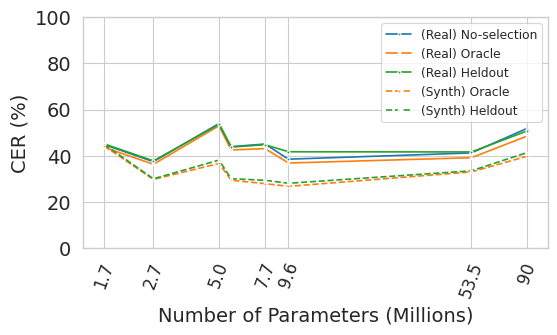

In [26]:
# Make a plot with the average CER for each architecture and model_selection with the hue as dataset (real or synthetic)

# show(pd_all_grouped_avg)
# pd_all_grouped_avg_melted = pd_all_grouped_avg.melt(id_vars='architecture', value_vars=['no-selection', 'oracle', 'heldout'], var_name='model_selection', value_name='CER')
# show(pd_all_grouped_avg_melted)

# show(pd_all_grouped_avg_params)
# pd_all_grouped_avg_params['n_parameters'] = pd_all_grouped_avg_melted['architecture'].apply(lambda x: 9.6 if x == 'CRNN' else 2.7 if x == 'VAN' else 1.7 if x == 'C-SAN' else 53.5 if x == 'HTR-VIT' else 90 if x == 'Kang' else 5 if x == 'Michael' else 7.7 if x == 'LT' else 5.6 if x == 'VLT' else 0.0)

# show(pd_all_grouped_avg_params)


fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# Make a plot with the average CER for each architecture and model_selection
sns.set_context("paper")
sns.set_style("whitegrid")

# Make melting per separate datasets
pd_all_grouped_real_avg = pd_all_grouped_avg[pd_all_grouped_avg['dataset'] == 'real']
pd_all_grouped_synthetic_avg = pd_all_grouped_avg[pd_all_grouped_avg['dataset'] == 'synthetic']

pd_all_grouped_real_avg['n_parameters'] = pd_all_grouped_avg_melted['architecture'].apply(lambda x: 9.6 if x == 'CRNN' else 2.7 if x == 'VAN' else 1.7 if x == 'C-SAN' else 53.5 if x == 'HTR-VIT' else 90 if x == 'Kang' else 5 if x == 'Michael' else 7.7 if x == 'LT' else 5.6 if x == 'VLT' else 0.0)
pd_all_grouped_synthetic_avg['n_parameters'] = pd_all_grouped_avg_melted['architecture'].apply(lambda x: 9.6 if x == 'CRNN' else 2.7 if x == 'VAN' else 1.7 if x == 'C-SAN' else 53.5 if x == 'HTR-VIT' else 90 if x == 'Kang' else 5 if x == 'Michael' else 7.7 if x == 'LT' else 5.6 if x == 'VLT' else 0.0)

pd_all_grouped_real_avg_melted = pd_all_grouped_real_avg 
pd_all_grouped_synthetic_avg_melted = pd_all_grouped_synthetic_avg


# pd_all_grouped_real_avg_melted = pd_all_grouped_real_avg.melt(id_vars='architecture', value_vars=['no-selection', 'oracle', 'heldout'], var_name='model_selection', value_name='CER')
# pd_all_grouped_synthetic_avg_melted = pd_all_grouped_synthetic_avg.melt(id_vars='architecture', value_vars=['no-selection', 'oracle', 'heldout'], var_name='model_selection', value_name='CER')

show(pd_all_grouped_real_avg_melted)
show(pd_all_grouped_synthetic_avg_melted)


# Set the y-axis limit
ax.set_ylim(0, 100)

# Create the linesplot differentiating between real and synthetic data. In reals there is no-selection, oracle and heldout. In synthetic there is only oracle and heldout

sns.lineplot(data=pd_all_grouped_real_avg_melted, x='n_parameters', y='no-selection', ax=ax, marker='o', markersize=2, label='(Real) No-selection', color='tab:blue')
sns.lineplot(data=pd_all_grouped_real_avg_melted, x='n_parameters', y='oracle', ax=ax, marker='X', markersize=2, label='(Real) Oracle', color='tab:orange')
sns.lineplot(data=pd_all_grouped_real_avg_melted, x='n_parameters', y='heldout', ax=ax, marker='D', markersize=2, label='(Real) Heldout', color='tab:green')

sns.lineplot(data=pd_all_grouped_synthetic_avg_melted, x='n_parameters', y='oracle', ax=ax, marker='o', markersize=2, label='(Synth) Oracle', color='tab:orange', linestyle='--')
sns.lineplot(data=pd_all_grouped_synthetic_avg_melted, x='n_parameters', y='heldout', ax=ax, marker='X', markersize=2, label='(Synth) Heldout', color='tab:green', linestyle='--')



# # sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='no-selection', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='No-selection')
# # sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='oracle', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='Oracle')
# # sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='heldout', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='Heldout')

# # Set line solid for no-selection, dashed for oracle and dotted for heldout
# sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='no-selection', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='No-selection')
# sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='oracle', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='Oracle', linestyle='--')
# sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='heldout', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='Heldout', linestyle=':')


# ax.set_ylim(30, 65)
# ax.set_yticks([30, 40, 50, 60])

ax.set_xscale('log')

ax.set_xticks([1.7, 2.7, 5, 7.7, 9.6, 53.5, 90])
ax.set_xticklabels(['1.7', '2.7', '5.0', '7.7', '9.6', '53.5', '90'], fontsize=12, rotation=70)

ax.set_xlabel("Number of Parameters (Millions)", fontsize=14)
ax.set_ylabel("CER (%)", fontsize=14)
ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=14)


# Save the figure in results with .pdf extension
plt.savefig('../results/parameters_real_synth.pdf', format='pdf', bbox_inches='tight')


In [27]:
# Get the best results for each arquitecture and test_dataset but having into account the language of the train dataset and the test dataset


In [28]:
# Read synthetic data again and get for each architecture the best and the second results for each test_dataset groping per language

pd_synthetic = pd.read_csv('../results/results_synth_final.csv')
pd_synthetic = pd_synthetic[columns]

# Apply the following dictionary to Name columns creating a new column called architecture removing before _src_ in name
pd_synthetic['architecture'] = pd_synthetic['Name'].apply(lambda x: x.split('_src_')[0])

# Drop if any of the columns contains a NaN value
pd_synthetic = pd_synthetic[['Name'] + ['architecture'] + columns[1:]]
# Melt the table to have each test/test_cer_{dataset} in a single column

pd_synthetic = pd.melt(pd_synthetic, id_vars=['Name', 'train_datasets', 'architecture'], value_vars=['test/test_cer_iam', 'test/test_cer_washington', 'test/test_cer_bentham', 'test/test_cer_rimes', 'test/test_cer_saint_gall', 'test/test_cer_rodrigo', 'test/test_cer_icfhr_2016'], var_name='test_dataset', value_name='CER')

# Remove test/test_cer_ from test_dataset
pd_synthetic['test_dataset'] = pd_synthetic['test_dataset'].apply(lambda x: x.removeprefix('test/test_cer_'))
pd_synthetic['train_datasets'] = pd_synthetic['train_datasets'].apply(lambda x: x.removeprefix('["').removesuffix('"]')).astype(str)
# pd_synthetic['train_datasets'] = pd_synthetic['train_datasets'].apply(lambda x: x.split('_')[0])

pd_synthetic['CER'] = pd_synthetic['CER'] * 100

# Cap the CER value to 100
pd_synthetic['CER'] = pd_synthetic['CER'].apply(lambda x: min(x, 100))
show(pd_synthetic)

# Get the best and second best results for each architecture and test_dataset. First and second best have to be different train_datasets
pd_synthetic = pd_synthetic.groupby(['architecture', 'test_dataset', 'train_datasets']).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)
show(pd_synthetic)

# Get for each architecture and test_dataset the best and second best results with different train_datasets
pd_best_synthetic = pd_synthetic.groupby(['architecture', 'test_dataset']).apply(lambda x: x.nsmallest(2, 'CER')).reset_index(drop=True)
show(pd_best_synthetic)



In [29]:
# Create a new table with the best and second best results in two separate columns for each architecture and test_dataset from pd_best_synthetic (remove duplicates)

pd_new_best_synthetic = pd.DataFrame()
pd_new_best_synthetic['architecture'] = pd_best_synthetic['architecture']
pd_new_best_synthetic['test_dataset'] = pd_best_synthetic['test_dataset']
pd_new_best_synthetic['best'] = pd_best_synthetic['CER']
pd_new_best_synthetic['second_best'] = pd_best_synthetic['CER'].shift(-1)
pd_new_best_synthetic['relative_diff'] = (pd_new_best_synthetic['second_best'] - pd_new_best_synthetic['best']) / pd_new_best_synthetic['best'] * 100
pd_new_best_synthetic = pd_new_best_synthetic.drop_duplicates(subset=['architecture', 'test_dataset'])
show(pd_new_best_synthetic)

In [30]:
# Get the average best and second best averaged per dataset for each architecture
pd_new_best_synthetic_avg = pd_new_best_synthetic.groupby('architecture').mean().reset_index()
pd_new_best_synthetic_avg['architecture'] = pd_new_best_synthetic_avg['architecture'].map(architectures_names)
show(pd_new_best_synthetic_avg)


/tmp/ipykernel_1719094/2677819484.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_new_best_synthetic_avg = pd_new_best_synthetic.groupby('architecture').mean().reset_index()


In [31]:
# Add type of alignment to the table 
# C-SAN: CTC, CRNN: CTC, HTR-VIT: CTC, Kang: AR, LT: AR, Michael: AR, VAN: CTC, VLT: AR
pd_new_best_synthetic_avg['Decoder'] = pd_new_best_synthetic_avg['architecture'].apply(lambda x: 'CTC' if x == 'CRNN' or x == 'VAN' or x == 'C-SAN' or x == 'HTR-VIT' else 'AR')
show(pd_new_best_synthetic_avg)

# Get mean relative difference for each alignment
pd_new_best_synthetic_avg_alignment = pd_new_best_synthetic_avg.groupby('Decoder').mean().reset_index()
show(pd_new_best_synthetic_avg_alignment)

/tmp/ipykernel_1719094/4090314784.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_new_best_synthetic_avg_alignment = pd_new_best_synthetic_avg.groupby('Decoder').mean().reset_index()


In [32]:
# Read data final_results_real.csv. The format is a column with dataset, CRNN, VAN, C-SAN-ARCE, HTR-VIT, Kang, Michael, LT, VLT and for each dataset there is two subcolumns: ID and OOD. Format the table to be readable

pd_real = pd.read_csv('../results/final_results_real.csv', sep=';')
# pd_real = pd_real.drop(columns=['Unnamed:' + str(i) for i in range(1, 19, 2)])

pd_real = pd_real.drop(columns=['Unnamed: 0'])
show(pd_real)

# This are the two first headers:
# Dataset	CRNN	Unnamed: 3	VAN	Unnamed: 5	C-SAN-ARCE	Unnamed: 7	HTR-VT	Unnamed: 9	Kang	Unnamed: 11	Michael	Unnamed: 13	LT	Unnamed: 15	VLT	Unnamed: 17	Unnamed: 18
# NaN	ID	OOD	ID	OOD	ID	OOD	ID	OOD	ID	OOD	ID	OOD	ID	OOD	ID	OOD	NaN

# Format the table to be readable. Differentiate between ID and OOD. Remove the first row and the last column
# pd_real = pd_real.dropna()

# Remove the last column
pd_real = pd_real.iloc[:, :-1]

# Remove the first row
pd_real = pd_real.iloc[1:, :]

show(pd_real)

# map_idx_archs = [('CRNN', 1), 'VAN': 3, 'C-SAN-ARCE': 5, 'HTR-VT': 7, 'Kang': 9, 'Michael': 11, 'LT': 13, 'VLT': 15]

# Change to have a list of tuples with the architecture name and the index of the first column
map_idx_archs = [('CRNN', 1), ('VAN', 3), ('C-SAN', 5), ('HTR-VIT', 7), ('Kang', 9), ('Michael', 11), ('LT', 13), ('VLT', 15)]

# Get id with map_idx_archs and ood with map_idx_archs + 1
pd_real_id = pd_real.iloc[:, [0] + [map_idx_archs[i][1] for i in range(len(map_idx_archs))]]
pd_real_ood = pd_real.iloc[:, [0] + [map_idx_archs[i][1] + 1 for i in range(len(map_idx_archs))]]

# Change column name to architecture
pd_real_id.columns = ['Dataset'] + [arch for arch, _ in map_idx_archs]
pd_real_ood.columns = ['Dataset'] + [arch for arch, _ in map_idx_archs]


# Every two rows is the architecture. The first row is ID and the second row is OOD. The first c

show(pd_real_id)
show(pd_real_ood)


/tmp/ipykernel_1719094/3261773399.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)
/tmp/ipykernel_1719094/3261773399.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=12)
/tmp/ipykernel_1719094/3261773399.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cers_ids = pd_real_id[arch].to_numpy().astype(np.float)
/tmp/ipykernel_1719094/3261773399.py:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence thi

-----------------
arch: CRNN. row: architecture          CRNN
best             26.735392
second_best       32.93659
relative_diff    35.844736
Decoder                CTC
difference       -6.201199
Name: 0, dtype: object. ood: 38.5
arch: VAN. row: architecture           VAN
best             29.690953
second_best      33.551774
relative_diff    17.473679
Decoder                CTC
difference       -3.860822
Name: 1, dtype: object. ood: 37.44285714285714
arch: LT. row: architecture            LT
best             27.877486
second_best      33.874929
relative_diff    33.395704
Decoder                 AR
difference       -5.997443
Name: 2, dtype: object. ood: 45.08571428571429
arch: VLT. row: architecture           VLT
best             29.397386
second_best      34.686601
relative_diff    26.304209
Decoder                 AR
difference       -5.289214
Name: 3, dtype: object. ood: 43.89999999999999
arch: HTR-VIT. row: architecture       HTR-VIT
best             32.985269
second_best       37.

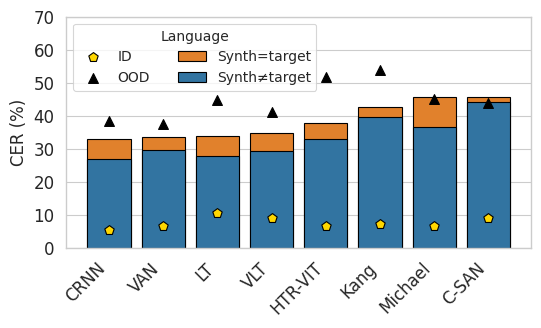

In [33]:
# Make a plot with the difference between the best and second best for each architecture as positive and negative values
sns.set_context("paper")
sns.set_style("whitegrid")

# New column with the difference between best and second best relative to the best value
# pd_new_best_synthetic_avg['difference'] = (pd_new_best_synthetic_avg['best'] - pd_new_best_synthetic_avg['second_best']) / pd_new_best_synthetic_avg['best'] * 100

# Compute the difference between original not with the mean
pd_new_best_synthetic_avg['difference'] = pd_new_best_synthetic_avg['best'] - pd_new_best_synthetic_avg['second_best']

show(pd_new_best_synthetic_avg)

# Sort by best value
pd_new_best_synthetic_avg = pd_new_best_synthetic_avg.sort_values('second_best').reset_index(drop=True)

# show(pd_new_best_synthetic_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Set the y-axis limit
ax.set_ylim(0, 70)


sns.barplot(data=pd_new_best_synthetic_avg, x='architecture', y='second_best', ax=ax, color='tab:orange', label='Synth=target', dodge=False, edgecolor='black')
sns.barplot(data=pd_new_best_synthetic_avg, x='architecture', y='best', ax=ax, color='tab:blue', label='Synth≠target', dodge=False, edgecolor='black')

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)  
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("CER (%)", fontsize=12)

# ax.set_yticks(fontsize=12)
ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=12)

print(f'-----------------')
# Add for each architecture the mean ID and OOD as point 
# Iterate per columns [1:] and get the mean of the ID and OOD. scatter in the plot

# Get the mean per architecture for ID and OOD
for i, (arch, idx) in enumerate(map_idx_archs):
  # Filter values for ID where CER > 30
  cers_ids = pd_real_id[arch].to_numpy().astype(np.float) 
  cer_id = cers_ids[cers_ids < 30]
  mean_id = cer_id.mean()
  mean_ood = pd_real_ood[arch].to_numpy().astype(np.float).mean()
  
  # print(mean_id, mean_ood)
  
  # Make horizontal line for ID and OOD
  # ax.plot([i - 0.4, i + 0.4], [mean_id, mean_id], color='green', linestyle='dotted', linewidth=1.8)
  # ax.plot([i - 0.4, i + 0.4], [mean_ood, mean_ood], color='red', linestyle='dotted', linewidth=1.8)
  
  ax.scatter(i, mean_id, color='gold', marker='p', zorder=10,s=50,  edgecolors='black')
  ax.scatter(i, mean_ood, color='black', marker="^", zorder=10,s=50, edgecolors='black')
  


# Draw a vertical line from average real OOD to second_best in synthetic
for i, row in pd_new_best_synthetic_avg.iterrows():
# I want sorted architectures so iter over map_idx_archs
# for i, (arch, idx) in enumerate(map_idx_archs):
  arch = row['architecture']
  print(f'arch: {arch}. row: {row}. ood: {pd_real_ood[arch].to_numpy().astype(np.float).mean()}')
  # arch = row['architecture']
  ood = pd_real_ood[arch].to_numpy().astype(np.float).mean()
  # min = np.min([row['second_best'], row['best']])
  # ax.plot([i, i], [row['best'], ood], color='black', linestyle='--', linewidth=0.8)
  # get min from best and second best
  
  # ax.text(i, row['best'] + 3, f"{np.round(row['best'] - ood, 1):.1f}%", fontsize=8, ha='center')
  


# Make two separate legends, one for languages and other for ID and OOD in real
ax.legend(title='Language', loc='upper center', fontsize=10, title_fontsize=10, ncol=2)


ax.scatter([], [], color='gold', label='ID', marker='p', s=50, edgecolors='black')
ax.scatter([], [], color='black', label='OOD', marker="^", s=50, edgecolors='black')

ax.legend(title='Language', loc='upper left', fontsize=10, title_fontsize=10, ncol=2)



# Save the figure in results with .pdf extension
plt.savefig('../results/synth_best_second_best.pdf', format='pdf', bbox_inches='tight')



In [34]:
# Get the sorted architectures per cer of synthetic data according to best and second best
pd_new_best_synthetic_avg = pd_new_best_synthetic_avg.sort_values('best').reset_index(drop=True)

In [35]:
# Get average differences between synthetic second best and OOD for each architecture
# Add columns architecture, abs_difference_best, abs_difference_second_best, relative_difference_best, relative_difference_second_best
avg_differences = pd.DataFrame(columns=['architecture', 'real_ood', 'abs_best', 'abs_second_best', 'relative_best', 'relative_second_best', 'abs_best_second_best', 'relative_best_second_best'])

avg_differences['architecture'] = pd_new_best_synthetic_avg['architecture']

for i, (arch, idx) in enumerate(map_idx_archs):
  mean_ood = pd_real_ood[arch].to_numpy().astype(np.float).mean()
  avg_differences.loc[i, 'real_ood'] = mean_ood
  
  # Get the difference between the best and the mean OOD
  diff = pd_new_best_synthetic_avg[pd_new_best_synthetic_avg['architecture'] == arch]['best'].values[0] - mean_ood
  diff_second = pd_new_best_synthetic_avg[pd_new_best_synthetic_avg['architecture'] == arch]['second_best'].values[0] - mean_ood
  avg_differences.loc[i, 'abs_best'] = diff
  avg_differences.loc[i, 'abs_second_best'] = diff_second
  
  
  # Get relative differences between the best and the mean OOD and between the second best and the mean OOD
  relative_diff_best = (pd_new_best_synthetic_avg[pd_new_best_synthetic_avg['architecture'] == arch]['best'].values[0] - mean_ood) / pd_new_best_synthetic_avg[pd_new_best_synthetic_avg['architecture'] == arch]['best'].values[0] * 100
  relative_diff_second_best = (pd_new_best_synthetic_avg[pd_new_best_synthetic_avg['architecture'] == arch]['second_best'].values[0] - mean_ood) / pd_new_best_synthetic_avg[pd_new_best_synthetic_avg['architecture'] == arch]['second_best'].values[0] * 100
  
  avg_differences.loc[i, 'abs_best_second_best'] = pd_new_best_synthetic_avg[pd_new_best_synthetic_avg['architecture'] == arch]['best'].values[0] - pd_new_best_synthetic_avg[pd_new_best_synthetic_avg['architecture'] == arch]['second_best'].values[0]
  avg_differences.loc[i, 'relative_best_second_best'] = (pd_new_best_synthetic_avg[pd_new_best_synthetic_avg['architecture'] == arch]['best'].values[0] - pd_new_best_synthetic_avg[pd_new_best_synthetic_avg['architecture'] == arch]['second_best'].values[0]) / pd_new_best_synthetic_avg[pd_new_best_synthetic_avg['architecture'] == arch]['best'].values[0] * 100
  
  avg_differences.loc[i, 'relative_best'] = relative_diff_best
  avg_differences.loc[i, 'relative_second_best'] = relative_diff_second_best
  
  
display(avg_differences)

# Display and sort by name
# display(pd.DataFrame(avg_differences.items(), columns=['architecture', 'difference']).sort_values('architecture'))

# Get the mean of the differences
# mean_difference = np.mean(list(avg_differences.values()))
# display(mean_difference)

# Display sorted by relative_best_second_best
display(avg_differences.sort_values('relative_best_second_best'))

# Sort 

# Get the mean of the differences
mean_difference = avg_differences.mean()
display(mean_difference)

/tmp/ipykernel_1719094/495323788.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mean_ood = pd_real_ood[arch].to_numpy().astype(np.float).mean()


architecture   real_ood   abs_best abs_second_best relative_best  \
0         CRNN       38.5 -11.764608        -5.56341    -44.003874   
1           LT  37.442857  -7.751905       -3.891083    -26.108642   
2          VLT       44.8  -0.500606         0.99611     -1.130052   
3          VAN  41.214286  -8.229016       -3.306215    -24.947549   
4      HTR-VIT  51.785714 -12.043887       -9.098623    -30.305319   
5      Michael  53.928571 -17.273317       -8.190602    -47.123713   
6         Kang  45.085714 -17.208229      -11.210785    -61.728051   
7        C-SAN       43.9 -14.502614       -9.213399    -49.333004   

  relative_second_best abs_best_second_best relative_best_second_best  
0           -16.891273            -6.201199                -23.194717  
1           -11.597248            -3.860822                -13.003361  
2             2.175098            -1.496716                 -3.378639  
3            -8.721666            -4.922801                -14.924241  
4           -21.314694            -2.945264                 -7.410994  
5           -17.907664            -9.082715                -24.778753  
6           -33.094638            -5.997443                -21.513574  
7            -26.56184            -5.289214                -17.992124

architecture   real_ood   abs_best abs_second_best relative_best  \
5      Michael  53.928571 -17.273317       -8.190602    -47.123713   
0         CRNN       38.5 -11.764608        -5.56341    -44.003874   
6         Kang  45.085714 -17.208229      -11.210785    -61.728051   
7        C-SAN       43.9 -14.502614       -9.213399    -49.333004   
3          VAN  41.214286  -8.229016       -3.306215    -24.947549   
1           LT  37.442857  -7.751905       -3.891083    -26.108642   
4      HTR-VIT  51.785714 -12.043887       -9.098623    -30.305319   
2          VLT       44.8  -0.500606         0.99611     -1.130052   

  relative_second_best abs_best_second_best relative_best_second_best  
5           -17.907664            -9.082715                -24.778753  
0           -16.891273            -6.201199                -23.194717  
6           -33.094638            -5.997443                -21.513574  
7            -26.56184            -5.289214                -17.992124  
3            -8.721666            -4.922801                -14.924241  
1           -11.597248            -3.860822                -13.003361  
4           -21.314694            -2.945264                 -7.410994  
2             2.175098            -1.496716                 -3.378639

/tmp/ipykernel_1719094/495323788.py:44: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_difference = avg_differences.mean()


real_ood                     44.582143
abs_best                    -11.159273
abs_second_best              -6.184751
relative_best               -35.585025
relative_second_best        -16.739241
abs_best_second_best         -4.974522
relative_best_second_best   -15.774550
dtype: float64

<Axes: xlabel='best', ylabel='difference'>

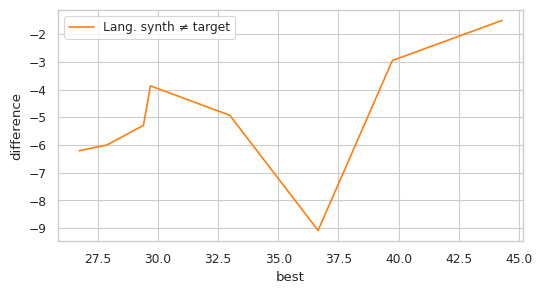

In [36]:
# Plot correlation between the best and the difference
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.lineplot(data=pd_new_best_synthetic_avg, x='best', y='difference', ax=ax, color='tab:orange', label='Lang. synth ≠ target')


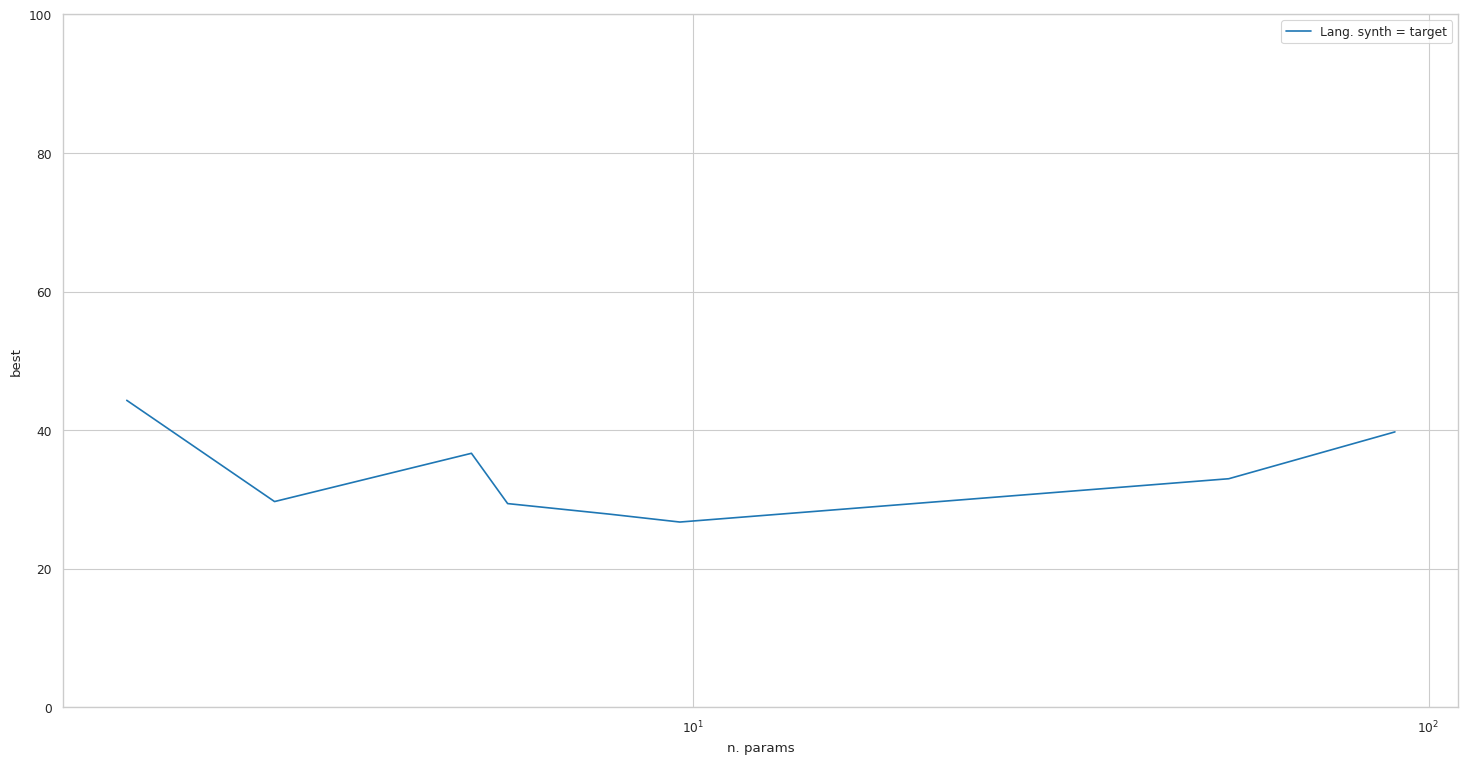

In [37]:
# Plot n. params vs. best and difference
fig, ax = plt.subplots(1, 1, figsize=(6*3, 3*3))

# Set the y-axis limit
ax.set_ylim(0, 100)

pd_new_best_synthetic_avg['n. params'] = pd_new_best_synthetic_avg['architecture'].apply(lambda x: 9.6 if x == 'CRNN' else 2.7 if x == 'VAN' else 1.7 if x == 'C-SAN' else 53.5 if x == 'HTR-VIT' else 90 if x == 'Kang' else 5 if x == 'Michael' else 7.7 if x == 'LT' else 5.6 if x == 'VLT' else 0.0)
sns.lineplot(data=pd_new_best_synthetic_avg, x='n. params', y='best', ax=ax, color='tab:blue', label='Lang. synth = target')

ax.set_xscale('log')

In [77]:
# Obtain for each best results in OOD the source dataset for each architecture

# read the results from the real data
pd_real = pd.read_csv('../results/results_all_final.csv')
pd_real = pd_real[columns]

# Apply the following dictionary to Name columns creating a new column called architecture removing before _src_ in name
pd_real['architecture'] = pd_real['Name'].apply(lambda x: x.split('_src_')[0])

# Drop if any of the columns contains a NaN value
pd_real = pd_real[['Name'] + ['architecture'] + columns[1:]]
# Melt the table to have each test/test_cer_{dataset} in a single column
pd_real = pd.melt(pd_real, id_vars=['Name', 'train_datasets', 'architecture'], value_vars=['test/test_cer_iam', 'test/test_cer_washington', 'test/test_cer_bentham', 'test/test_cer_rimes', 'test/test_cer_saint_gall', 'test/test_cer_rodrigo', 'test/test_cer_icfhr_2016'], var_name='test_dataset', value_name='CER')

# Remove test/test_cer_ from test_dataset
pd_real['test_dataset'] = pd_real['test_dataset'].apply(lambda x: x.removeprefix('test/test_cer_'))

pd_real['train_datasets'] = pd_real['train_datasets'].apply(lambda x: x.removeprefix('["').removesuffix('"]'))
pd_real['train_datasets'] = pd_real['train_datasets'].apply(lambda x: x.removeprefix('"').removesuffix('"')).astype(str)

print(pd_real['train_datasets'].unique())
print(pd_real['test_dataset'].unique())

pd_real['scenario'] = pd_real.apply(lambda x: 'ID' if x['train_datasets'] == x['test_dataset'] else 'OOD', axis=1)

pd_real = pd_real[pd_real['scenario'] == 'OOD']

# Filter only where ID is in Name
pd_real = pd_real[pd_real['Name'].str.contains('ID')]

pd_real['CER'] = pd_real['CER'] * 100


# Get the best results for each architecture and test_dataset and finally get the source dataset
pd_real = pd_real.groupby(['architecture', 'test_dataset', 'train_datasets']).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)
show(pd_real)
pd_real = pd_real.groupby(['architecture', 'test_dataset']).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)
show(pd_real)

# Get the source dataset for each architecture and test_dataset
pd_real['source_dataset'] = pd_real['train_datasets']

pd_best_source = pd_real[['architecture', 'test_dataset', 'source_dataset', 'CER']]

# pd_new_best_synthetic_avg['architecture'].map(architectures_names)
pd_best_source['architecture'] = pd_best_source['architecture'].map(architectures_names)
show(pd_best_source)




['rimes' 'icfhr_2016' 'rodrigo' 'saint_gall' 'bentham' 'washington' 'iam']
['iam' 'washington' 'bentham' 'rimes' 'saint_gall' 'rodrigo' 'icfhr_2016']


/tmp/ipykernel_1719094/3183840840.py:35: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pd_real = pd_real.groupby(['architecture', 'test_dataset', 'train_datasets']).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)


/tmp/ipykernel_1719094/3183840840.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_best_source['architecture'] = pd_best_source['architecture'].map(architectures_names)


In [73]:
# Transform pd_best_source to have architectures as columns and test_datasets as rows. Each cell is the source dataset
pd_best_source_piv = pd_best_source.pivot(index='test_dataset', columns='architecture', values='source_dataset').reset_index()
show(pd_best_source_piv)

# Set the following order for architectures: CRNN, VAN, C-SAN, HTR-VIT, Kang, Michael, LT, VLT
# Set the following order for test_datasets: iam, washington, bentham, rimes, saint_gall, rodrigo, icfhr_2016

# Set the order for architectures
pd_best_source_piv = pd_best_source_piv[['test_dataset'] + ['CRNN', 'VAN', 'C-SAN', 'HTR-VIT', 'Kang', 'Michael', 'LT', 'VLT']]
show(pd_best_source_piv)

# Set the order for test_datasets
pd_best_source_piv = pd_best_source_piv.set_index('test_dataset')
pd_best_source_piv = pd_best_source_piv.reindex(['iam', 'washington', 'bentham', 'rimes', 'saint_gall', 'rodrigo', 'icfhr_2016'])
show(pd_best_source_piv)


In [75]:
# Map each name of the dataset to a more readable name inside each test_dataset and each cell
datasets_names = dict({
  'iam': 'IAM', 'washington': 'G.W.', 'bentham': 'Bentham', 'rimes': 'Rimes', 'saint_gall': 'S.G.', 'rodrigo': 'Rodrigo', 'icfhr_2016': 'ICFHR 2016'
})

pd_best_source_piv = pd_best_source_piv.applymap(lambda x: datasets_names[x] if x in datasets_names else x)
show(pd_best_source_piv)

# Also change the test_datasets row names
pd_best_source_piv = pd_best_source_piv.rename(index=datasets_names)
show(pd_best_source_piv)

In [100]:
# get same results for pd_best_source but for WER
pd_real = pd.read_csv('../results/results_all_final_wer.csv')
columns = ['Name', 'train_datasets', 'test/test_wer_iam', 'test/test_wer_washington', 'test/test_wer_bentham', 'test/test_wer_rimes', 'test/test_wer_saint_gall', 'test/test_wer_rodrigo', 'test/test_wer_icfhr_2016']
# pd_real = pd_real[columns]

# Apply the following dictionary to Name columns creating a new column called architecture removing before _src_ in name
pd_real['architecture'] = pd_real['Name'].apply(lambda x: x.split('_src_')[0])

# Drop if any of the columns contains a NaN value
pd_real = pd_real[['Name'] + ['architecture'] + columns[1:]]

# Melt the table to have each test/test_WER_{dataset} in a single column
pd_real = pd.melt(pd_real, id_vars=['Name', 'train_datasets', 'architecture'], value_vars=['test/test_wer_iam', 'test/test_wer_washington', 'test/test_wer_bentham', 'test/test_wer_rimes', 'test/test_wer_saint_gall', 'test/test_wer_rodrigo', 'test/test_wer_icfhr_2016'], var_name='test_dataset', value_name='WER')

# Remove test/test_WER_ from test_dataset
pd_real['test_dataset'] = pd_real['test_dataset'].apply(lambda x: x.removeprefix('test/test_wer_'))

pd_real['train_datasets'] = pd_real['train_datasets'].apply(lambda x: x.removeprefix('["').removesuffix('"]'))
pd_real['train_datasets'] = pd_real['train_datasets'].apply(lambda x: x.removeprefix('"').removesuffix('"')).astype(str)

print(pd_real['train_datasets'].unique())
print(pd_real['test_dataset'].unique())

pd_real['scenario'] = pd_real.apply(lambda x: 'ID' if x['train_datasets'] == x['test_dataset'] else 'OOD', axis=1)

pd_real = pd_real[pd_real['scenario'] == 'OOD']

# Filter only where ID is in Name
pd_real = pd_real[pd_real['Name'].str.contains('ID')]
pd_real['WER'] = pd_real['WER'] * 100


# Get the best results for each architecture and test_dataset and finally get the source dataset
pd_real = pd_real.groupby(['architecture', 'test_dataset', 'train_datasets']).apply(lambda x: x.nsmallest(1, 'WER')).reset_index(drop=True)
# show(pd_real)
pd_real = pd_real.groupby(['architecture', 'test_dataset']).apply(lambda x: x.nsmallest(1, 'WER')).reset_index(drop=True)
# show(pd_real)

# Get the source dataset for each architecture and test_dataset
pd_best_source = pd_real[['architecture', 'test_dataset', 'WER']]

# pd_new_best_synthetic_avg['architecture'].map(architectures_names)
pd_best_source['architecture'] = pd_best_source['architecture'].map(architectures_names)
# show(pd_best_source)


# Transform pd_best_source to have architectures as columns and test_datasets as rows. Each cell is the source dataset
# Transform pd_best_source to have architectures as columns and test_datasets as rows. Each cell is the source dataset
pd_best_source_piv = pd_best_source.pivot(index='test_dataset', columns='architecture', values='WER').reset_index()
# show(pd_best_source_piv)

# Set the following order for architectures: CRNN, VAN, C-SAN, HTR-VIT, Kang, Michael, LT, VLT
# Set the following order for test_datasets: iam, washington, bentham, rimes, saint_gall, rodrigo, icfhr_2016

# Set the order for architectures
pd_best_source_piv = pd_best_source_piv[['test_dataset'] + ['CRNN', 'VAN', 'C-SAN', 'HTR-VIT', 'Kang', 'Michael', 'LT', 'VLT']]
# show(pd_best_source_piv)

# Set the order for test_datasets
pd_best_source_piv = pd_best_source_piv.set_index('test_dataset')
pd_best_source_piv = pd_best_source_piv.reindex(['iam', 'rimes', 'washington', 'bentham', 'saint_gall', 'rodrigo', 'icfhr_2016'])
                                                 
                                                #  'washington', 'bentham', 'rimes', 'saint_gall', 'rodrigo', 'icfhr_2016'])

# Map each name of the dataset to a more readable name inside each test_dataset and each cell
datasets_names = dict({
  'iam': 'IAM', 'washington': 'G.W.', 'bentham': 'Bentham', 'rimes': 'Rimes', 'saint_gall': 'S.G.', 'rodrigo': 'Rodrigo', 'icfhr_2016': 'ICFHR 2016'
})

# Change it for test_datasets rows
pd_best_source_piv = pd_best_source_piv.rename(index=datasets_names)

# Round to 1 decimal
# show(pd_best_source_piv.round(1))

# Add a row with the average of the WER for each architecture
pd_best_source_piv.loc['Average'] = pd_best_source_piv.mean()
show(pd_best_source_piv.round(1))

['rimes' 'icfhr_2016' 'rodrigo' 'saint_gall' 'bentham' 'washington' 'iam']
['iam' 'washington' 'bentham' 'rimes' 'saint_gall' 'rodrigo' 'icfhr_2016']


/tmp/ipykernel_1719094/47573160.py:34: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pd_real = pd_real.groupby(['architecture', 'test_dataset', 'train_datasets']).apply(lambda x: x.nsmallest(1, 'WER')).reset_index(drop=True)
/tmp/ipykernel_1719094/47573160.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_best_source['architecture'] = pd_best_source['architecture'].map(architectures_names)


In [101]:
# get same results for pd_best_source but for WER and for ID scenario

pd_real = pd.read_csv('../results/results_all_final_wer.csv')
columns = ['Name', 'train_datasets', 'test/test_wer_iam', 'test/test_wer_washington', 'test/test_wer_bentham', 'test/test_wer_rimes', 'test/test_wer_saint_gall', 'test/test_wer_rodrigo', 'test/test_wer_icfhr_2016']
# pd_real = pd_real[columns]

# Apply the following dictionary to Name columns creating a new column called architecture removing before _src_ in name
pd_real['architecture'] = pd_real['Name'].apply(lambda x: x.split('_src_')[0])

# Drop if any of the columns contains a NaN value
pd_real = pd_real[['Name'] + ['architecture'] + columns[1:]]

# Melt the table to have each test/test_WER_{dataset} in a single column
pd_real = pd.melt(pd_real, id_vars=['Name', 'train_datasets', 'architecture'], value_vars=['test/test_wer_iam', 'test/test_wer_washington', 'test/test_wer_bentham', 'test/test_wer_rimes', 'test/test_wer_saint_gall', 'test/test_wer_rodrigo', 'test/test_wer_icfhr_2016'], var_name='test_dataset', value_name='WER')

# Remove test/test_WER_ from test_dataset
pd_real['test_dataset'] = pd_real['test_dataset'].apply(lambda x: x.removeprefix('test/test_wer_'))

pd_real['train_datasets'] = pd_real['train_datasets'].apply(lambda x: x.removeprefix('["').removesuffix('"]'))
pd_real['train_datasets'] = pd_real['train_datasets'].apply(lambda x: x.removeprefix('"').removesuffix('"')).astype(str)

print(pd_real['train_datasets'].unique())
print(pd_real['test_dataset'].unique())

pd_real['scenario'] = pd_real.apply(lambda x: 'ID' if x['train_datasets'] == x['test_dataset'] else 'OOD', axis=1)

pd_real = pd_real[pd_real['scenario'] == 'ID']

# Filter only where ID is in Name
pd_real = pd_real[pd_real['Name'].str.contains('ID')]
pd_real['WER'] = pd_real['WER'] * 100


# Get the best results for each architecture and test_dataset and finally get the source dataset
pd_real = pd_real.groupby(['architecture', 'test_dataset', 'train_datasets']).apply(lambda x: x.nsmallest(1, 'WER')).reset_index(drop=True)
# show(pd_real)
pd_real = pd_real.groupby(['architecture', 'test_dataset']).apply(lambda x: x.nsmallest(1, 'WER')).reset_index(drop=True)
# show(pd_real)

# Get the source dataset for each architecture and test_dataset
pd_best_source = pd_real[['architecture', 'test_dataset', 'WER']]

# pd_new_best_synthetic_avg['architecture'].map(architectures_names)
pd_best_source['architecture'] = pd_best_source['architecture'].map(architectures_names)
# show(pd_best_source)


# Transform pd_best_source to have architectures as columns and test_datasets as rows. Each cell is the source dataset
# Transform pd_best_source to have architectures as columns and test_datasets as rows. Each cell is the source dataset
pd_best_source_piv = pd_best_source.pivot(index='test_dataset', columns='architecture', values='WER').reset_index()
# show(pd_best_source_piv)

# Set the following order for architectures: CRNN, VAN, C-SAN, HTR-VIT, Kang, Michael, LT, VLT
# Set the following order for test_datasets: iam, washington, bentham, rimes, saint_gall, rodrigo, icfhr_2016

# Set the order for architectures
pd_best_source_piv = pd_best_source_piv[['test_dataset'] + ['CRNN', 'VAN', 'C-SAN', 'HTR-VIT', 'Kang', 'Michael', 'LT', 'VLT']]
# show(pd_best_source_piv)

# Set the order for test_datasets
pd_best_source_piv = pd_best_source_piv.set_index('test_dataset')
# pd_best_source_piv = pd_best_source_piv.reindex(['iam', 'washington', 'bentham', 'rimes', 'saint_gall', 'rodrigo', 'icfhr_2016'])
pd_best_source_piv = pd_best_source_piv.reindex(['iam', 'rimes', 'washington', 'bentham', 'saint_gall', 'rodrigo', 'icfhr_2016'])

# Map each name of the dataset to a more readable name inside each test_dataset and each cell
datasets_names = dict({
  'iam': 'IAM', 'washington': 'G.W.', 'bentham': 'Bentham', 'rimes': 'Rimes', 'saint_gall': 'S.G.', 'rodrigo': 'Rodrigo', 'icfhr_2016': 'ICFHR 2016'
})

# Change it for test_datasets rows
pd_best_source_piv = pd_best_source_piv.rename(index=datasets_names)

# Round to 1 decimal
# show(pd_best_source_piv.round(1))

# Add a row with the average of the WER for each architecture
pd_best_source_piv.loc['Average'] = pd_best_source_piv.mean()
show(pd_best_source_piv.round(1))

['rimes' 'icfhr_2016' 'rodrigo' 'saint_gall' 'bentham' 'washington' 'iam']
['iam' 'washington' 'bentham' 'rimes' 'saint_gall' 'rodrigo' 'icfhr_2016']


/tmp/ipykernel_1719094/3576131435.py:35: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pd_real = pd_real.groupby(['architecture', 'test_dataset', 'train_datasets']).apply(lambda x: x.nsmallest(1, 'WER')).reset_index(drop=True)
/tmp/ipykernel_1719094/3576131435.py:37: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., g